* Calculate relative levels of activity and polarization in each activity category

In [1]:
partisan_dimen = "partisan"

In [3]:
import sys
import os
sys.path.append("..")
from commembed.jupyter import *
import commembed.linalg as linalg
import commembed.dimens as dimens
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from tqdm.notebook import tqdm
tqdm.pandas()
%config InlineBackend.figure_format = 'retina'
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
from pyspark.sql.functions import *

import commembed.data as data


spark = data.spark_context()

%load_ext autoreload
%autoreload 2

Spark WebUI: http://ada.ais.sandbox:4045


In [4]:
user_counts = data.load("all_objects_monthly_user_counts")
user_counts.createOrReplaceTempView("user_counts")

scores_dfs = []
for cat in ["all","left","right","center"]:
    df, _ = load_abs_z_df(partisan_dimen, political_activity_category=cat)
    df["category"] = cat
    scores_dfs.append(df.reset_index())
    
scores = pd.concat(scores_dfs)
display(scores)
scores_df = spark.createDataFrame(scores.reset_index())
scores_df.createOrReplaceTempView("scores")

(Freshly loading table all_objects_monthly_user_counts)
Spark WebUI: http://ada.ais.sandbox:4045
553 political subreddits selected
Spark WebUI: http://ada.ais.sandbox:4045
208 political subreddits selected
Spark WebUI: http://ada.ais.sandbox:4045
103 political subreddits selected
Spark WebUI: http://ada.ais.sandbox:4045
242 political subreddits selected


,community,partisan_dimen,category
0,politics,1.023831,all
1,worldnews,0.951234,all
2,news,0.467755,all
3,The_Donald,4.370756,all
4,atheism,1.289769,all
...,...,...,...
237,paradoxpolitics,0.342102,center
238,Stand,0.129003,center
239,FreeSpeech,0.061734,center
240,media,0.160844,center


In [5]:
filtered_counts = spark.sql("select * from user_counts inner join scores on subreddit = community")
filtered_counts.createOrReplaceTempView("filtered_counts")

avg_z_by_month = spark.sql("""
    select month, category,
        sum(num_comments) as num_comments,
        sum(partisan_dimen*num_comments)/sum(num_comments) as avg_abs_z
    from filtered_counts
    group by 1, 2
""").toPandas()

<AxesSubplot:xlabel='month'>

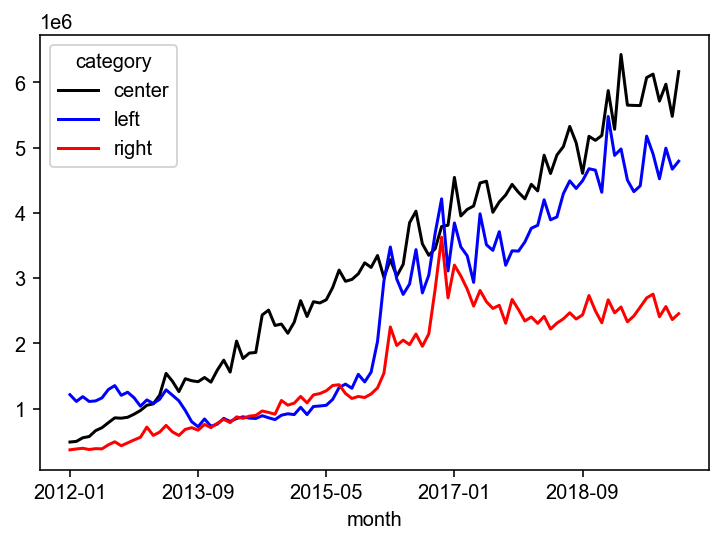

In [7]:
# Num comments
avg_pivoted = avg_z_by_month.pivot(index="month", columns="category", values="num_comments")
avg_pivoted = avg_pivoted[avg_pivoted.index > "2012"]

avg_pivoted[["center","left","right"]].plot.line(color=['black','blue','red'])

/u/walleris/miniconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1182: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:xlabel='month'>

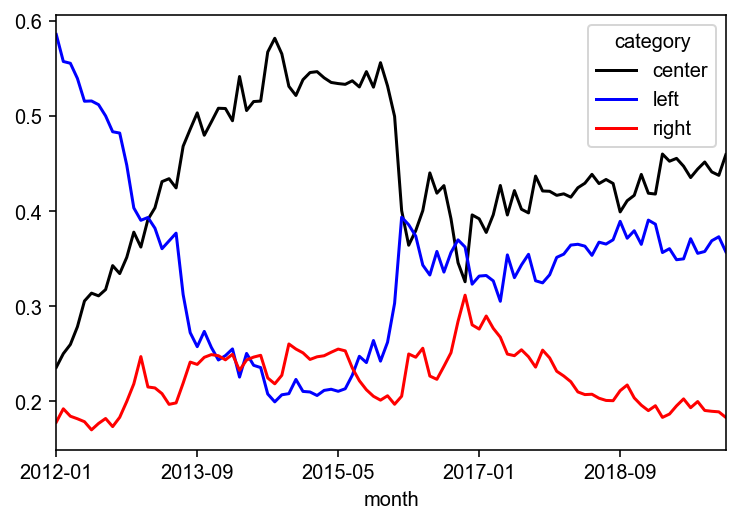

In [6]:
# Activity levels
avg_pivoted = avg_z_by_month.pivot(index="month", columns="category", values="num_comments")
avg_pivoted = avg_pivoted[avg_pivoted.index > "2012"]
avg_pivoted["sum"] = avg_pivoted["center"] + avg_pivoted["left"] + avg_pivoted["right"]

avg_pivoted[["center","left","right"]] = avg_pivoted[["center","left","right"]] \
    .divide(avg_pivoted["all"], axis='index')

avg_pivoted[["center","left","right"]].plot.line(color=['black','blue','red'])

/u/walleris/miniconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1182: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:xlabel='month'>

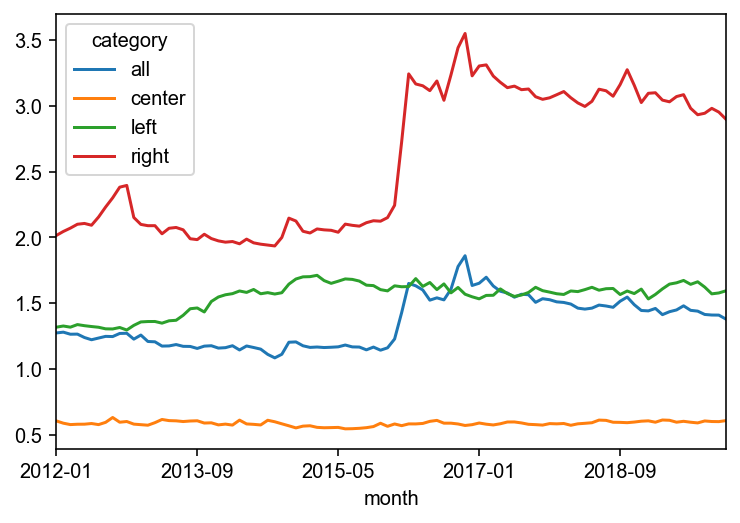

In [8]:
# Average polarization
avg_pivoted = avg_z_by_month.pivot(index="month", columns="category", values="avg_abs_z")
avg_pivoted = avg_pivoted[avg_pivoted.index > "2012"]
avg_pivoted.plot.line()

In [9]:
# Save
avg_z_by_month.to_csv(
    os.path.join(data.DATA_PATH, "monthly_polarization_by_category_%s.csv" % partisan_dimen))